# Primeros ejemplos

Iniciaremos nuestra exploración de los sistemas de recomendación con los ejemplos más básicos. Estos primeros ejemplos nos permitirán explorar nuestro conjunto de datos en primera instancia y, en casos concretos donde no dispongamos de datos pueden servir como una base o primera aproximación muy socorrida.

## Conjuntos de datos: MovieLens

Procederemos a descargarnos la información del conjunto de datos recopilado por el equipo de investigación [grouplens](https://grouplens.org/datasets/movielens/) de la Universidad de Minesota bajo su trabajo previo hecho público:

F. Maxwell Harper and Joseph A. Konstan. 2015. **The MovieLens Datasets: History and Context**. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

Es un conjunto de datos muy utilizado en el ámbito de los sistemas de recomendación y por ello encontraréis multitud de ejemplos donde podréis ver representados los mismos datos y evaluar vuestras soluciones frente a las publicadas.

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve

In [2]:
# Descarga del conjunto de datos
print("Descargando el conjunto de datos...")

urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

print(f"Descargado! Numero de elementos descargados {info}")

Descargando el conjunto de datos...
Descargado! Numero de elementos descargados b'943 users\n1682 items\n100000 ratings\n'


## Usuarios (Users)

Como toda plataforma los usuarios son la pieza clave que motiva las necesidades de recomendación. Por ello deberemos conocer bien a nuestro público.

In [3]:
# Cargamos los datos de los usuarios
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Podemos ver cómo es la estructura base de nuestro conjunto de usuarios donde disponemos de rangos de edad, sexo, ocupación y código postal informado.

<AxesSubplot:xlabel='age', ylabel='Count'>

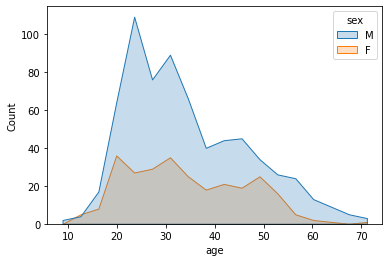

In [4]:
# Muestra ejemplo de la distribución de edad po sexo
sns.histplot(users, x="age", hue="sex", element="poly")

También podemos entender como es la distribución de edad por ocupación. Este tipo de conocimiento es lo que en muchos casos permite hacer asunciones de los gustos base que esperamos en poblaciones concretas por ocupación, rango de edad, país de residencia,...

<AxesSubplot:xlabel='age', ylabel='occupation'>

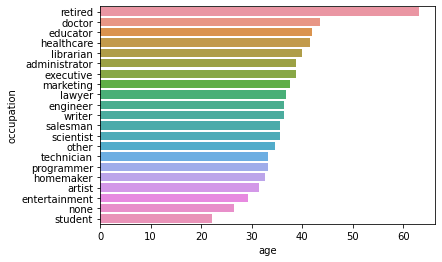

In [5]:
data = users.groupby("occupation")["age"].mean()
data = data.reset_index().sort_values("age", ascending=False)
sns.barplot(y="occupation",x="age", data=data)


También podemos obtener los datos relativos a las ocupaciones con mayor actividad en la plataforma.

### Ejercicio

In [6]:
"""
Ejercicio : Realizar las operaciones necesarias para descubrir las ocupaciones más activas
"""
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
users.occupation.value_counts()

student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
homemaker          7
doctor             7
Name: occupation, dtype: int64

In [7]:
common_users = users[users["occupation"].isin(["student", "other","educator"])]

<AxesSubplot:xlabel='age', ylabel='Count'>

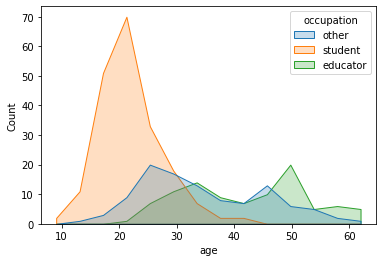

In [8]:
sns.histplot(common_users, x="age", hue="occupation", element="poly")

## Ítems (Movies)

Las películas serán para nosotros los items a recomendar a nuestros usuarios. Obtendremos los datos del conjunto base y además complementaremos aquella información que enriquezca nuestro conocimiento sobre estas pelíoculas de cara a recomendar aquellas que sean del agrado de nuestros usuarios.

In [9]:
# Cargamos las películas
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
movies.head(10)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1995
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1996


Podemos ver que el conjunto de base ya contiene el etiquetado de los generos de cada película en formato [OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Es una forma sencilla de codificar variables categoricas de forma que podamos utilizarlas de forma numérica. Ahondaremos en esto más adelante.

Veamos ahora cual es la distribución de nuestros ítems por genero.

### Ejercicio

In [10]:
"""
Ejercicio : Realizar las operaciones necesarias para descubrir los ítems por género y conocer la distribución de items en nuestro dominio
"""
df=movies[genre_cols].sum().sort_values(ascending=False)
df

Drama            725
Comedy           505
Action           251
Thriller         251
Romance          247
Adventure        135
Children         122
Crime            109
Sci-Fi           101
Horror            92
War               71
Mystery           61
Musical           56
Documentary       50
Animation         42
Western           27
Film-Noir         24
Fantasy           22
genre_unknown      2
dtype: int64

<AxesSubplot:>

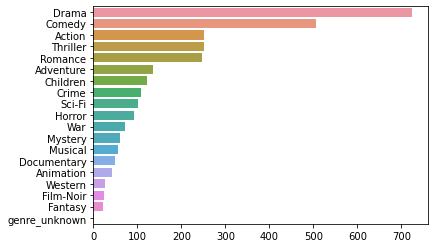

In [11]:
x = df.tolist()
y = df.index.tolist()
sns.barplot(x=x,y=y)

Disponemos de información relativa al contenido, pero es importante poder valorar qué películas son las mejor valoradas entre el público o cuales son las más populares (más vistas). Para ello deberemos cargar el tercer conjunto relevante para nuestro sistema de recomendación.

## Ratings

Finalmente, los ratings son los que recogen las impresiones de los usuarios con respecto a los ítems, dandonos la posibilidad de adecuar en base a dichos gustos la oferta a cada usuario.

In [12]:
# Cargamos las puntuaciones otorgadas por usuarios a películas vistas en un rango entre 1 a 5
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


Gracias a estos rating podremos, por ejemplo, buscar aquellas películas más populares.

### Ejercicio

In [13]:
"""
Ejercicio : Realizar las operaciones necesarias para conocer los ítem valorados más veces
"""
titles = movies[['title', 'movie_id']]
df = pd.merge(ratings, titles, on='movie_id')
df.title.value_counts()

Star Wars (1977)                   583
Contact (1997)                     509
Fargo (1996)                       508
Return of the Jedi (1983)          507
Liar Liar (1997)                   485
                                  ... 
Leopard Son, The (1996)              1
Stefano Quantestorie (1993)          1
Quartier Mozart (1992)               1
Reluctant Debutante, The (1958)      1
Dadetown (1995)                      1
Name: title, Length: 1664, dtype: int64

Veremos que las películas más populares pueden no ser las mejor valoradas.

In [14]:
"""
Ejercicio : Realizar las operaciones necesarias para conocer los ítem mejor valorados
"""
df1=df.groupby('title')['rating'].mean().sort_values(ascending=False)
df1

title
They Made Me a Criminal (1939)                  5.0
Marlene Dietrich: Shadow and Light (1996)       5.0
Saint of Fort Washington, The (1993)            5.0
Someone Else's America (1995)                   5.0
Star Kid (1997)                                 5.0
                                               ... 
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
King of New York (1990)                         1.0
Touki Bouki (Journey of the Hyena) (1973)       1.0
Bloody Child, The (1996)                        1.0
Crude Oasis, The (1995)                         1.0
Name: rating, Length: 1664, dtype: float64

Una vez conocemos nuestro conjunto de datos podemos plantearnos cómo deberían ser esas primeras recomendaciones a realizar.

# Recomendadores por popularidad

Es uno de los ejemplos más sencillos donde no se requiere información alguna de los usuarios. Los ítems más populares pueden ser un buen reclamo ante la presencia de un usuario del que nos dispongamos de información. En el ámbito de los recomendadores esta carencia de información se conoce como *cold start*.

Permite presentar a un nuevo usuario de una plataforma con información posiblemente de su interés dada la popularidad de esta para otros usuarios.

Podemos buscar la relación entre las métricas anteriormente vistas (número de puntuaciones y promedio de las mismas) de cara a entender mejor la relación existente entre estas. Nuestro primer recomendador podría simplemente ofrecernos la películas más populares o las mejor valoradas (o una combinación de ambas). Crearemos un conjunto de datos base que deberemos actualizar cada vez que se disponga de nueva información sobre nuestra colección de ítems (películas).

In [15]:
ratings_df = pd.DataFrame(df.groupby('movie_id')['rating'].count())
ratings_df

,rating
movie_id,
1,452
2,131
3,90
4,209
5,86
...,...
1678,1
1679,1
1680,1


### Ejercicio

In [16]:
"""
Ejercicio : Construiremos un DataFrame que combine los índices de popularidad y mejor valorados para los ítems
"""
ratings_df1 = pd.DataFrame(df.groupby('movie_id')['rating'].count())
ratings_df2 = pd.DataFrame(df.groupby('movie_id')['rating'].mean())
ratings_df=pd.merge(ratings_df1, ratings_df2,how="left", on=["movie_id"])
ratings_df["score"]=ratings_df["rating_x"]*ratings_df["rating_y"]
ratings_df.rename(columns={"rating_y":"num_rating","rating_x":"mean_ratings"},inplace=True)
ratings_df=ratings_df.sort_values(by=['score'],ascending=False)
ratings_df

,mean_ratings,num_rating,score
movie_id,,,
50,583,4.358491,2541.0
100,508,4.155512,2111.0
181,507,4.007890,2032.0
258,509,3.803536,1936.0
174,420,4.252381,1786.0
...,...,...,...
1581,1,1.000000,1.0
1570,1,1.000000,1.0
1486,1,1.000000,1.0


Con esta información podremos en base a la popularidad de las películas no vistas por el usuario, realizar una primera recomendación.

### Ejercicio

In [17]:
  """
  Ejercicio: Devolveremos las diez películas más vistas y mejor valoradas que no haya visto el usuario indicado por user_id
  """
def popularity_based_recommender(user_id:int):
  # Obtenemos 100 candidatos a ser recomendados (por disponer de una muestra de generación)
    top_rated = df1[100]

  # Obtenemos las películas ya vistas por el usuario
    already_seen = ratings[ratings["user_id"] == user_id]

  # Nos quedamos con aquellas no vistas del conjunto inicial
    return_df = movies[movies]

  # Añadimos el título y ofrecemos diez candidatas
    return ...


In [18]:
movies[movies not in(ratings[ratings["user_id"] == 1])]

TypeError: unhashable type: 'DataFrame'

In [ ]:
popularity_based_recommender(1)

In [ ]:
popularity_based_recommender(196)

Esta modalidad de recomendación es quizás de las más sencillas y en cualquier caso, unicamente diponiendo de la información asociada a los ítems vistos por los usuarios puede contarse con una recomendación sobre los títulos más populares. Dentro del caracter general de estos modos de recomendación estas recomendaciones pueden ser segregadas por popularidad entre adolescentes o algún perfil laboral en concreto para lo cual necesitaremos algo más de información asociada al usuario en cuestión que valoramos.

# La importancia de la similitud

Un factor interesante a la hora de recomendar contenido es la similitud que este pueda presentar con contenido ya visto por el usuario en cuestión y del que haya mostrado buen feedback (ratings altos en nuestro caso).

Veremos que este mismo conceptoo es extensible a los usuarios (contenido visto por usuarios similares a mi) pero por el momento nos limitaremos a conocer los gustos de nuestro usuario candidato. Para ello deberemos obtener sus películas favoritas.

In [19]:
def favorite_movies(user_id:int, num=10):
  """
  Devolveremos los 10 títulos mejor valorados por un usuario
  """
  # Obtenemos las películas ya vistas por el usuario
  rated = ratings[ratings["user_id"] == user_id]
  
  # Las películas valoradas por este
  rated_info = pd.merge(rated, titles, on='movie_id')[["movie_id","title","rating"]]
  return rated_info.sort_values(by='rating', ascending=False).head(num)

In [20]:
favorite_movies(196)

,movie_id,title,rating
27,285,Secrets & Lies (1996),5.0
14,692,"American President, The (1995)",5.0
4,655,Stand by Me (1986),5.0
5,67,Ace Ventura: Pet Detective (1994),5.0
31,153,"Fish Called Wanda, A (1988)",5.0
8,663,Being There (1979),5.0
12,286,"English Patient, The (1996)",5.0
15,8,Babe (1995),5.0
29,1007,Waiting for Guffman (1996),4.0
30,411,"Nutty Professor, The (1996)",4.0


In [21]:
favorite_movies(1)

,movie_id,title,rating
136,170,Cinema Paradiso (1988),5.0
67,175,Brazil (1985),5.0
182,119,Maya Lin: A Strong Clear Vision (1994),5.0
186,181,Return of the Jedi (1983),5.0
191,109,Mystery Science Theater 3000: The Movie (1996),5.0
77,44,Dolores Claiborne (1994),5.0
75,14,"Postino, Il (1994)",5.0
74,12,"Usual Suspects, The (1995)",5.0
194,223,Sling Blade (1996),5.0
72,108,Kids in the Hall: Brain Candy (1996),5.0


Conociendo los gustos de los usuarios sería interesante poder recomendar películas _similares_ de forma que maximicemos la experiencia de nuestro usuario. Podemos así ofrecerle contenido afin a sus gustos registrados. Y aquí es donde entran en juego las méticas de similitud.

Las métricas de similitud pretenden establecer un valor numérico de cómo de similares son dos elementos. El rango variará en base a la métrica en cuestión de modo que os presentamos algunas de las más comunes.

## Similitud coseno

Es una métrica popular ya que nos permite disponer de una métrica indicando 0 como dos elementos nada similares y 1 cuendo los elementos comparados son idénticos. Su formulación se expresa:

$S_c(A,B) = cos(\theta) = \frac{A · B}{\|A\|\|B\|} = \frac{\sum_{i=1}^n A_iB_i}{\sqrt{\sum_{i=1}^n A_i^2 \sum_{i=1}^n B_i^2}} $

donde $A_i$ y $B_i$ son los componentes de los vectores formados por las características de nuestros items. En el próximo ejemplo veremos cómo podemos comparar muestras basadas en los generos informados.


## Distancia de Jaccard

Formulada como se muestra a continuación:

$ J(A, B) = \frac{|A \cap B|}{|A \cup B|}$

Establece el número de elementos que se encuentran en la conjunción de ambos conjuntos (en nuestro caso podrían ser los generos asociados a una película) y en base a esto establece un índice donde la total coincidencia dará como resultado 1.0. 

En muchos casos no hará falta que codifiquemos nosotros mismos estas métricas ya que existen muchas de ellas ya codificadas bajo la librería *sklearn* en su sección de [métricas](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise).

### Ejercicio

In [ ]:
from sklearn.metrics.pairwise import ...

"""
Ejercicio: Calcularemos la matriz de similitud de los ítems seleccionando unicamente el comapo "movie_id" y las columnas de generos
"""
cosine_sim = ...

Con esto hemos construido un comparador basado en los géneros de las películas, de modo que si indicamos que nos gusa un Drama nos ofrecerá títulos simialres (Dramas). Evidentemente, cuanta más información dispongamos del contenido más precisas serán estas métricas.

In [ ]:
# Convertimos nuestra matriz en un DataFrame con índices y columnas indicando la relación entre películas
sim_matrix = pd.DataFrame(cosine_sim)
sim_matrix.columns = movies['movie_id'].values
sim_matrix.index += 1
sim_matrix

In [ ]:
def find_similar(movie_id):
  # Obtenemos las métricas para las peliculas
  m_list = sim_matrix.loc[movie_id].tolist()
  # Filtramos por aquellas simialres
  similar_movies = [i+1 for i,x in enumerate(m_list) if x >= 0.99]
  # Devolvemos los titulos
  return movies[movies["movie_id"].isin(similar_movies)][["title"] + genre_cols]

In [ ]:
find_similar(1)

In [ ]:
find_similar(7)

In [ ]:
find_similar(1500)

Al igual que la similitud de coseno, disponemos de otras métricas como la *distancia de Jaccard* o la *correlación de Pearson* que aportan esta misma visión sobre la proximidad entre distintos items en base a sus campos informados. Podemos completar los datos disponibles con información sobre los actores de las películas, lenguajes en las que se encuentran disponibles o directores de forma que cuanta más información contextual tengamos sobre los items, más precisas serán las métricas de similitud. Existen escenarios donde una métricas ofrecerán resultados más robustos que el resto, debido a la codificación de los campos, uso de valores discretos o conínuos, etc. Será nuestra labor entender cual es la mejor métrica en cada caso.

Estas métrica de similitud nos permiten realizar recomendaciones mucho más elavoradas que permitan adecuar las recomendaciones a los gustos del usuario basados en contenidos similares.

# Recomendadores basadas en contenido

El **filtrado basado en contenido** nos permite definir una vez conocemos los gustos y preferencias de un usuario (ítems visitados, visualizados o puntuados) ofrecerle ítems similares (basados en alguna distancia).

Una ves los usuarios empiezan a interactuar con la plataforma y a ofrecernos información sobre directores o actores favoritos podemos tener en cuenta estos gustos a la hora de recomendar la películas donde estos aparezcan.

En nuestro caso, podremos recurrir a los generos más consumidos o mejor valorados.

### Ejercicio

In [ ]:
def content_based_recommender(user_id, num=10):
   """
   Ejercicio: Devolvemos el numero de películas indicadas a recomendar que el usuario no haya visto y sean 
   similares a las películas vistas y puntuadas con un rating alto por el mismo usuario.
   """
   # Películas mejor puntuadas por el usuario
   fav_movies = favorite_movies(user_id, 10)

   # Películas no vistas por el usuario (candidatas)
   ...

   # Para cada película buscamos en su matriz de similitud lo títulos más similares, 
   # su máxima similitud con las películas valoradas y nos quedamos con las num primeras
   chosen_movies = ...

   return titles[titles["movie_id"].isin(chosen_movies)]

In [ ]:
favorite_movies(196)

In [ ]:
content_based_recommender(196)

In [ ]:
favorite_movies(1)

In [ ]:
content_based_recommender(1)